#### Importing modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mode
import chiCa
from spks import *

%matplotlib widget

#### Loading sync data

In [3]:
from spks.sync import load_ni_sync_data,interp1d
sessionpath = Path('/home/data/GRB006/20240429_174359/')
sync_port = 0 # this is where the SMA of the probe is connected

(nionsets,nioffsets),(nisync,nimeta),(apsyncdata) = load_ni_sync_data(sessionpath=sessionpath)
aponsets = apsyncdata[0]['file0_sync_onsets'][6] # this should be the same for you, its where the sync is on the probe

corrected_onsets = {} # This is a dictionary with the digital events that were connected to the breakout box.
for k in nionsets.keys():
    corrected_onsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nionsets[k]).astype('uint64')

# if you need analog channels those are in "nisync"
nitime = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(np.arange(len(nisync)))

# everything is in samples, use this sampling rate
srate = apsyncdata[0]['sampling_rate']  

frame_rate = mode(1/(np.diff(corrected_onsets[1])/srate)) #corrected_onsets[1] are the frame samples, [2] are the trial start samples
trial_start_times = corrected_onsets[2][:-1]/srate


#### Loading behavioral data

In [4]:
behavior_data = chiCa.load_trialdata('/home/data/GRB006/20240429_174359/chipmunk/GRB006_20240429_174359_chipmunk_DemonstratorAudiTask.mat')

# stim_period_times = np.zeros(shape=(len(behavior_data),1))
# relative_stim_period_times = np.zeros(shape=(len(behavior_data),1))

# for trial, _ in behavior_data.PlayStimulus.items(): #unpacking index as trial and omitting the data
#     stim_period_times[trial] = behavior_data.trial_start_time[trial] + behavior_data.PlayStimulus[trial][0]
#     relative_stim_period_times[trial] = behavior_data.PlayStimulus[trial][0]


# stim_period_times = stim_period_times.flatten()
# relative_stim_period_times = relative_stim_period_times.flatten()

/opt/conda/envs/spks-gabriel/lib/python3.12/site-packages/chiCa/chipmunk_analysis_tools.py:321: UserWarning: Found multisensory trials, assumed synchronous condition
  warnings.warn('Found multisensory trials, assumed synchronous condition')


#### Get stimulus onsets aligned to nidaq time

It's not exactly aligned to hybrid time as it's trial start (nidaq) + stimulus timestamps (Bpod)

In [5]:
stim_onsets = trial_start_times + behavior_data.stimulus_event_timestamps

first_stim_onsets = np.zeros(len(stim_onsets))
for trial, timestamps in enumerate(stim_onsets):
    if np.isnan(timestamps[0]):
        first_stim_onsets[trial] = np.nan
    else:
        first_stim_onsets[trial] = timestamps[0]

first_stim_onsets = first_stim_onsets[~np.isnan(first_stim_onsets)]
# first_stim_onsets.shape

Verifying that it worked...

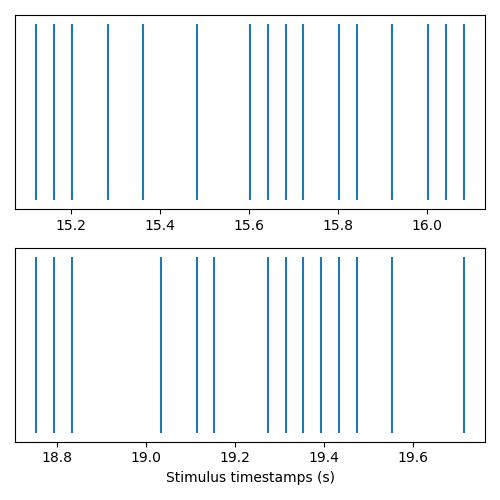

In [7]:
fig, axs = plt.subplots(len(stim_onsets[:2]), 1, figsize=(5,5))
for i, trials in enumerate(stim_onsets[:2]):
    axs[i].vlines(stim_onsets[i], 0, 1)
    axs[i].get_yaxis().set_visible(False)
axs[-1].set_xlabel('Stimulus timestamps (s)')
fig.tight_layout()

##### Load clusters object for current session to obtain cluster IDs

Also filtering units using Melin et al. 2024 preprint criteria

In [8]:
# binary_path = Path('/home/data/GRB006/20240429_174359/ephys_g0/ephys_g0_imec0/ephys_g0_t0.imec0.ap.bin')
# fast_binary_path = Path('/scratch/GRB/temp_bin/ephys_g0_t0.imec0.ap.bin')
kilosort_path = Path('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/')

clu = Clusters(folder = kilosort_path, get_waveforms=False, get_metrics=True, load_template_features=True)

# ---------- this gets the row indices ---------- #
single_unit_idx = np.where((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))[0]

# ---------- and this get the cluster_id values ---------- #
mask = ((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))


single_unit_ids = clu.cluster_info[mask].cluster_id.values

#### Code from tutorial
https://github.com/jcouto/cshl_spks/blob/main/tutorials/tutorial_plot_psths.ipynb

In [9]:
sc = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_clusters.npy')
ss = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_times.npy')

Text(0, 0.5, 'Number of trials')

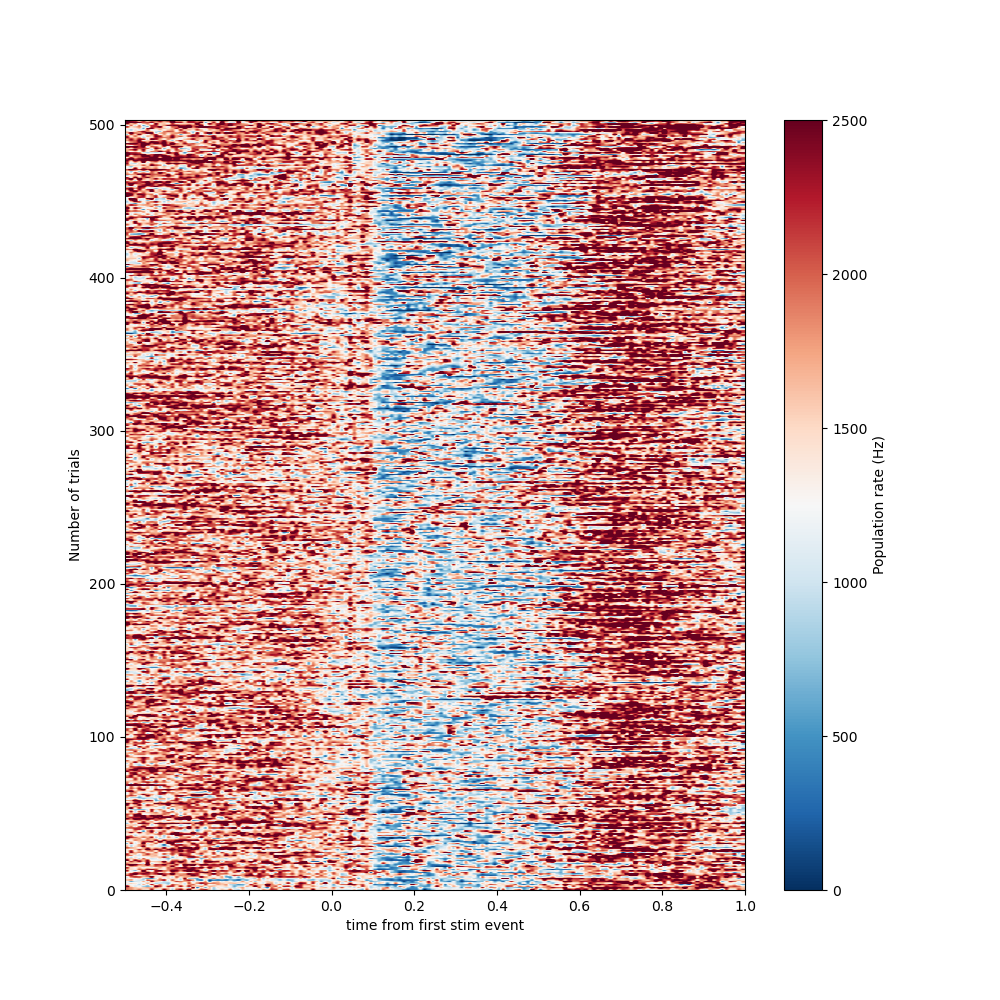

In [74]:
st = ss/srate

selection = np.isin(sc,single_unit_ids)

binsize = 0.01 # lets use a 10ms binsize
edges = np.arange(0,np.max(st[selection]),binsize)

pop_rate,_ = np.histogram(st[selection],edges)
pop_rate = pop_rate/binsize
pop_rate_time = edges[:-1]+np.diff(edges[:2])/2

psth = []
tpre = 0.5
tpost = 1
 
for onset in first_stim_onsets:
    psth.append(pop_rate[(pop_rate_time>= onset -tpre) & (pop_rate_time< onset +tpost)])
psth = np.stack(psth)
fig1 = plt.figure(figsize=(10,10))
plt.imshow(psth,aspect='auto',extent=[-tpre,tpost,0,len(psth)],cmap = 'RdBu_r',clim = [0,2500])
plt.colorbar(label='Population rate (Hz)')
plt.xlabel('time from first stim event')
plt.ylabel('Number of trials')

In [75]:
clus = sc[selection]
# separate the spikes from each unit
timestamps = [st[selection][clus == uclu] for uclu in np.unique(clus)]

trig_ts = []
for sp in timestamps:
    trig_ts.append([])
    for o in first_stim_onsets:
        trig_ts[-1].append(sp[(sp>=(o-tpre)) & (sp<(o+tpost))] - o)

In [ ]:
#interesting units to plot
#excitation: 67, 28, 29, 32, 105, 136, 151, 154, 209, 216
#inhibition: 4, 82, 84, 67, 82, 99, 106, 162, 166, 167

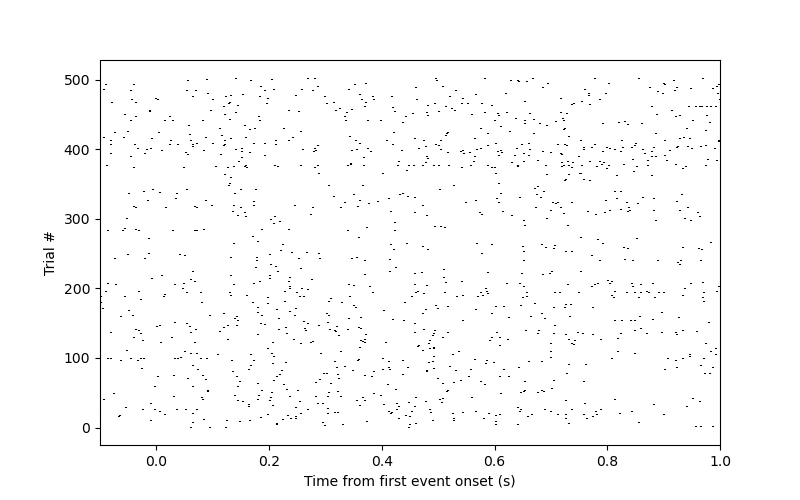

In [77]:
from useful_functions import individual_raster_viewer

individual_raster_viewer(trig_ts)

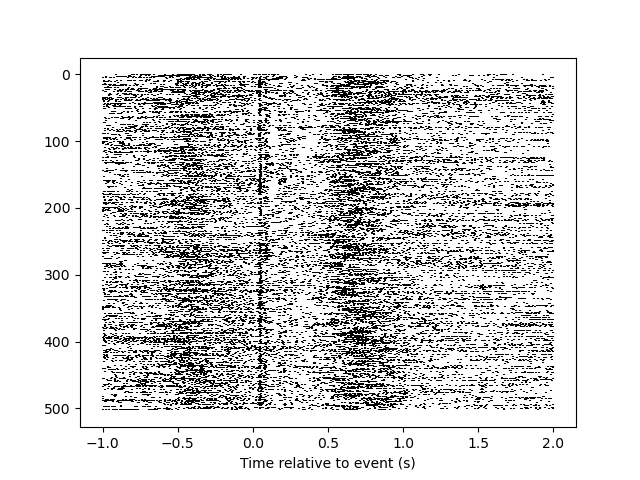

In [34]:
from spks.viz import plot_event_aligned_raster

fig, ax = plt.subplots(1,1)
plot_event_aligned_raster(event_times=first_stim_onsets, spike_times=timestamps[154], ax=ax)
fig.tight_layout()


Getting triggered spikes: 100%|██████████| 230/230 [00:00<00:00, 1001.00it/s]


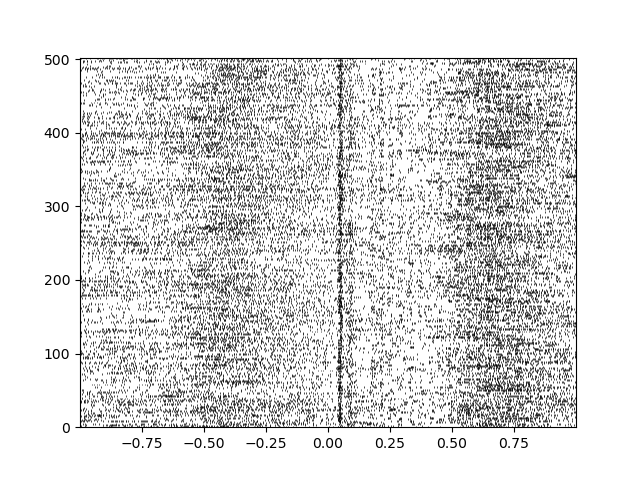

In [90]:
from spks.event_aligned import *

tspks = get_triggered_spikes(timestamps,first_stim_onsets,tpre = 1,tpost = 1)

fig = plt.figure()
plot_raster(spks=tspks[154])

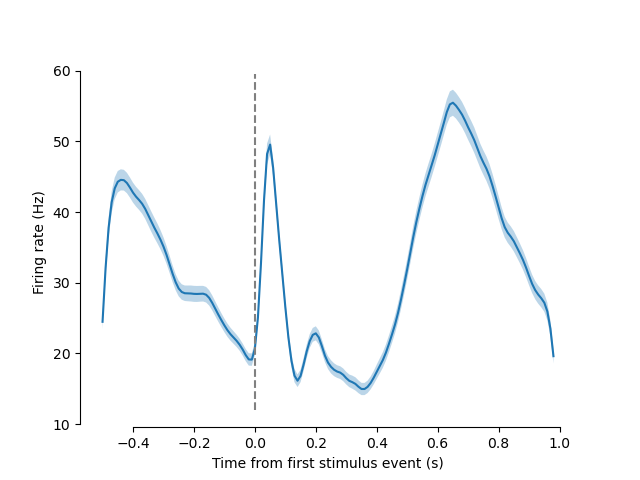

In [173]:
from useful_functions import separate_axes

pre = 0.5
post = 1
binw = 0.01

psth_matrix, event_index = compute_firing_rate(event_times=first_stim_onsets, spike_times=timestamps[154], pre_seconds=pre, post_seconds=post, binwidth_ms=int(binw*1000), kernel=gaussian_function(2))
trial_avg_psth = np.mean(psth_matrix, axis=0)
trial_sem_psth = np.std(psth_matrix, axis=0) / np.sqrt(psth_matrix.shape[0])

fig = plt.figure()
x_nums = np.arange(-pre, post, binw)
plt.plot(x_nums[:-1], trial_avg_psth)
plt.fill_between(x_nums[:-1], trial_avg_psth - trial_sem_psth, trial_avg_psth + trial_sem_psth, alpha=0.3)
plt.vlines([0], ymin = plt.ylim()[0], ymax = plt.ylim()[1], linestyles='dashed', color='gray')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time from first stimulus event (s)')

ax = plt.gca()
separate_axes(ax)

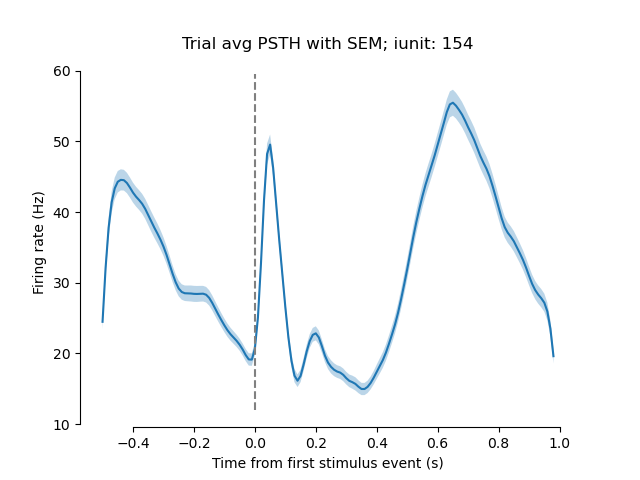

In [183]:
import numpy as np
import matplotlib.pyplot as plt

def plot_psth(iunit, event_times, spike_times, pre=0.5, post=1, binw=0.01, kernel_width=2):
    """
    Plots the Peri-Stimulus Time Histogram (PSTH) with SEM shading.
    
    Parameters:
    - event_times: array-like, times of the stimulus events.
    - spike_times: array-like, times of the spikes.
    - pre: float, time window before the stimulus event.
    - post: float, time window after the stimulus event.
    - binw: float, bin width for the histogram.
    - kernel_width: float, width of the Gaussian kernel for smoothing.
    """
    psth_matrix, event_index = compute_firing_rate(
        event_times=event_times,
        spike_times=spike_times[iunit],
        pre_seconds=pre,
        post_seconds=post,
        binwidth_ms=int(binw * 1000),
        kernel=gaussian_function(kernel_width)
    )
    
    trial_avg_psth = np.mean(psth_matrix, axis=0)
    trial_sem_psth = np.std(psth_matrix, axis=0) / np.sqrt(psth_matrix.shape[0])

    fig = plt.figure()
    x_nums = np.arange(-pre, post, binw)
    plt.plot(x_nums[:-1], trial_avg_psth, label='Average PSTH')
    plt.fill_between(x_nums[:-1], trial_avg_psth - trial_sem_psth, trial_avg_psth + trial_sem_psth, alpha=0.3, label='SEM')
    plt.vlines([0], ymin=plt.ylim()[0], ymax=plt.ylim()[1], linestyles='dashed', color='gray')
    plt.xlabel('Time from first stimulus event (s)')
    plt.ylabel('Firing rate (Hz)')
    plt.title(f'Trial avg PSTH with SEM; iunit: {iunit}')

    ax = plt.gca()
    separate_axes(ax)  # Assuming separate_axes is defined elsewhere

# Example usage:
plot_psth(iunit = 154, event_times=first_stim_onsets, spike_times=timestamps)

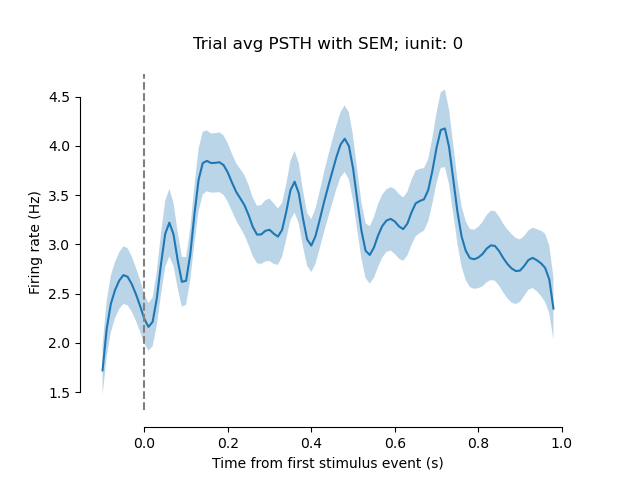

In [196]:
def plot_psth(iunit, event_times, spike_times, pre=0.5, post=1, binw=0.01, kernel_width=2):
    """
    Plots the Peri-Stimulus Time Histogram (PSTH) with SEM shading.
    
    Parameters:
    - event_times: array-like, times of the stimulus events.
    - spike_times: array-like, times of the spikes.
    - pre: float, time window before the stimulus event.
    - post: float, time window after the stimulus event.
    - binw: float, bin width for the histogram.
    - kernel_width: float, width of the Gaussian kernel for smoothing.
    """
    psth_matrix, event_index = compute_firing_rate(
        event_times=event_times,
        spike_times=spike_times[iunit],
        pre_seconds=pre,
        post_seconds=post,
        binwidth_ms=int(binw * 1000),
        kernel=gaussian_function(kernel_width)
    )
    
    trial_avg_psth = np.mean(psth_matrix, axis=0)
    trial_sem_psth = np.std(psth_matrix, axis=0) / np.sqrt(psth_matrix.shape[0])

    x_nums = np.arange(-pre, post, binw)
    plt.plot(x_nums[:-1], trial_avg_psth, label='Average PSTH')
    plt.fill_between(x_nums[:-1], trial_avg_psth - trial_sem_psth, trial_avg_psth + trial_sem_psth, alpha=0.3, label='SEM')
    plt.vlines([0], ymin=plt.ylim()[0], ymax=plt.ylim()[1], linestyles='dashed', color='gray')
    plt.xlabel('Time from first stimulus event (s)')
    plt.ylabel('Firing rate (Hz)')
    plt.title(f'Trial avg PSTH with SEM; iunit: {iunit}')

    ax = plt.gca()
    separate_axes(ax)  # Assuming separate_axes is defined elsewhere

def individual_psth_viewer(event_times, spike_times, pre=0.1, post=1, binw=0.01, kernel_width=2):
    from ipywidgets import IntSlider, Button, HBox, VBox
    from IPython.display import display
    # Create the slider and buttons
    fig = plt.figure()
    ax = plt.gca()
    slider = IntSlider(min=0, max=len(timestamps) - 1, step=1, value=0)
    next_button = Button(description="Next")
    prev_button = Button(description="Previous")

    # Define button click event handlers
    def on_next_button_clicked(b):
        slider.value = min(slider.value + 1, slider.max)

    def on_prev_button_clicked(b):
        slider.value = max(slider.value - 1, slider.min)

    # Attach event handlers to buttons
    next_button.on_click(on_next_button_clicked)
    prev_button.on_click(on_prev_button_clicked)

    # Update plot when slider value changes
    def on_slider_value_change(change):
        ax.clear()
        plot_psth(change['new'], event_times = event_times, spike_times = spike_times, pre = pre, post = post, binw = binw, kernel_width = kernel_width)

    slider.observe(on_slider_value_change, names='value')

    # Display buttons and slider
    display(VBox([HBox([prev_button, next_button]), slider]))

    # Initial plot
    plot_psth(iunit = slider.value, event_times = event_times, spike_times = spike_times, pre = pre, post = post, binw = binw, kernel_width = kernel_width)

individual_psth_viewer(event_times = first_stim_onsets, spike_times = timestamps)

In [191]:
len(timestamps)

230